<a href="https://colab.research.google.com/github/gustavoalcantara/data-porfolio/blob/main/geospatial_etl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adapting geospatial data for BigQuery
- Geospatial data holds great importance as it encompasses precise information about the geometry of phenomena or the exact location of objects on the Earth's surface or subsurface. When conducting geospatial analysis in BigQuery, it is necessary for the data to adhere to a standardized format where the geometry type is specified as either "geography" or "geometry". The provided Colab notebook offers a set of ETL (Extract, Transform, Load) processes that can be employed to convert a .shp file into GeoJSON or WKT formats. Additionally, it demonstrates the practical implementation using the "basedosdados" Python package to conduct a basic geospatial analysis.


Transform to GeoJson

In [ ]:
#Installing the packages
!pip install geopandas -q
!pip install fiona -q
!pip install basedosdados -q
!pip install shapely -q
!pip install mapclassify -q

In [4]:
#import the packages
import geopandas as gpd
import basedosdados as bd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapely
from shapely import wkt
import mapclassify

In [ ]:
#Upload of all files from .shp
gdf = gpd.read_file('malaria.shp')

In [ ]:
#Convert to a GeoJSON
gdf.to_file(filename ='malaria', driver='GeoJSON')

In [ ]:
#Reading the archive
gdf = gpd.read_file('/content/malaria')

In [ ]:
#The content of geometry
gdf['geometry'].describe()

count                               64
unique                              64
top       POINT (-60.6769333 -2.57989)
freq                                 1
Name: geometry, dtype: object

<Axes: >

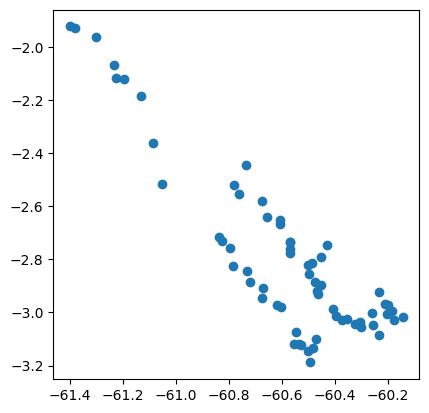

In [ ]:
gdf.plot()

Transform to a WKT

In [ ]:
#With my previously shapefile added, lets convert to a Well Known Text (WKT)
gdf = gpd.read_file('malaria.shp')

In [ ]:
#conversion to a wkt/geometry
gdf['geometry'] = gdf['geometry'].apply(lambda wkt: loads(wkt))
gdf = gdf.set_geometry('geometry')

In [ ]:
gdf['geometry'].describe()

count                               64
unique                              64
top       POINT (-60.6769333 -2.57989)
freq                                 1
Name: geometry, dtype: object

<Axes: >

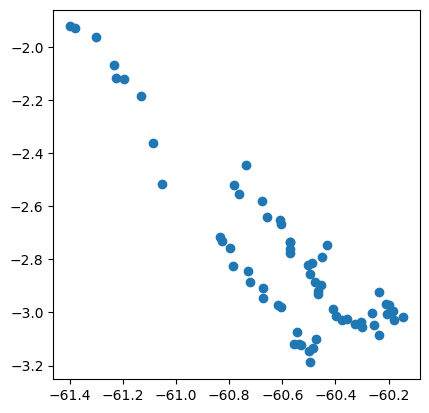

In [ ]:
#Remember: this points doesnt have a EPSG or Datum.
gdf.plot()

Assigning a WKT from a txt/csv file that does not have a prior spatial attribution

In [ ]:
#Reading the .txt or .csv
x = pd.read_csv('condicao_entrevistado.txt', sep ='\t')

#Assigning the EPSG to declare the lat/long as a spatial file
crs = {'init': 'epsg:4326'}

#String replace from comma to point of spatial variables
x['x'] = x['x'].str.replace(',', '.')
x['y'] = x['y'].str.replace(',', '.')

#Change to Float64
x['x'] = x['x'].astype(np.float64)
x['y'] = x['y'].astype(np.float64)

#Assigning the geometry variables
from shapely.geometry.polygon import Point
geometry = [Point(xy) for xy
            in zip(x['x'], x['y'])]

#For being a point, it became point, if polygon, assign polygon and so on
geo_df = gpd.GeoDataFrame(x,
                          crs = crs,
                          geometry = geometry)
geo_df['geometry'].head()

0    POINT (-60.67693 -2.57989)
1    POINT (-60.26111 -3.00310)
2    POINT (-60.30543 -3.03741)
3    POINT (-60.35581 -3.02633)
4    POINT (-60.49681 -2.85660)
Name: geometry, dtype: geometry

<Axes: >

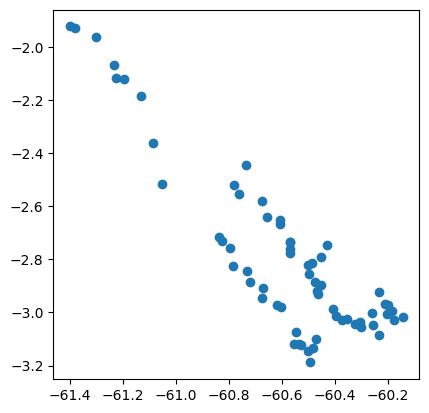

In [ ]:
geo_df.plot()

After this treatment, it is possible to upload the spatial variable as geometry to the datalake. I use the .csv format and include the geometry format in the variable’s metadata. For this, I use the basedosdados package in python for filling and validating metadata. In this sense, the generated file follows this metadata standard and you can [check it](https://github.com/basedosdados/mais/blob/master/bases/br_geobr_mapas/municipio/table_config.yaml)


# Spatial Analysis and Visualizations

# The Query and Correction


Now, let’s use geospatial data to generate a simple analysis in a .sql query of the distribution of the value of the built m² in the year 2023 in the city of São Paulo. In this query, I analyzed the 1000 highest and lowest values of the square meter in São Paulo in 2023. For this, I used the Geosampa base available in the particular datalake of basedosdados. In Bigquery, it is possible to perform geospatial analyses according to your needs. I need to analyze the points that overlapped in the city of São Paulo because some points in the general dataframe didn't do.  

In [5]:
query = '''
WITH city AS (
  SELECT ST_GeogFromText(geometria) AS geometry
  FROM `basedosdados.br_geobr_mapas.municipio`
  WHERE id_municipio = '3550308'
),
points AS (
  WITH top1000 AS (
  SELECT
    b.cep,
    b.logradouro,
    b.bairro,
    cidade,
    AVG(valor_construcao) as valor_construcao,
    ST_CENTROID_AGG(centroide) as centroide
  FROM `basedosdados.br_sp_saopaulo_geosampa_iptu.iptu` a
  INNER JOIN `basedosdados.br_bd_diretorios_brasil.cep` b
  ON a.cep = b.cep
  WHERE ano = 2023 AND id_municipio = '3550308' AND
  cidade = 'São Paulo'
  GROUP BY cep, logradouro, bairro, cidade
  ORDER BY valor_construcao DESC
  LIMIT 1000
),
under1000 AS (
  SELECT
    b.cep,
    b.logradouro,
    b.bairro,
    cidade,
    AVG(valor_construcao) as valor_construcao,
    ST_CENTROID_AGG(centroide) as centroide
  FROM `basedosdados.br_sp_saopaulo_geosampa_iptu.iptu` a
  INNER JOIN `basedosdados.br_bd_diretorios_brasil.cep` b
  ON a.cep = b.cep
  WHERE ano = 2023 AND valor_construcao > 0.0 AND id_municipio = '3550308'AND
  cidade = 'São Paulo'
  GROUP BY cep, logradouro, bairro, cidade
  ORDER BY valor_construcao ASC
  LIMIT 1000
)
SELECT * FROM top1000
UNION ALL
SELECT * FROM under1000
)
SELECT
  cep,
  logradouro,
  bairro,
  cidade,
  valor_construcao,
  centroide
FROM points, city
WHERE ST_WITHIN(points.centroide, city.geometry)
'''

df= bd.read_sql(query, billing_project_id='basedosdados-dev')

Downloading: 100%|██████████| 1974/1974 [00:00<00:00, 5628.29rows/s]


In [6]:
df.head()

,cep,logradouro,bairro,cidade,valor_construcao,centroide
0,05005900,"Rua Palestra Itália, 500",Perdizes,São Paulo,39980.0,POINT(-46.6808813 -23.5264274)
1,04543907,"Avenida Presidente Juscelino Kubitschek, 1909",Vila Nova Conceição,São Paulo,39980.0,POINT(-46.6878048 -23.5911938)
2,04005912,"Rua Curitiba, 195",Paraíso,São Paulo,38610.0,POINT(-46.6536281 -23.5815795)
3,01311924,"Avenida Paulista, 1345",Bela Vista,São Paulo,36590.0,POINT(-46.6548193 -23.563233)
4,05425902,"Avenida das Nações Unidas, 7221",Pinheiros,São Paulo,36590.0,POINT(-46.7023257 -23.5653763)


In the context of using geospatial data in BigQuery, it is necessary to correct them when importing them into Python. This is because the pandas backend (which the Base dos Dados package uses) does not support geospatial data.


In [7]:
# Are all observations wkt Points?
from shapely.geometry import Point
df['centroide'].apply(lambda x: isinstance(x, Point)).all()

False

The correct of points:

In [8]:
df.loc[~df['centroide'].apply(lambda x: isinstance(x, Point))]
#Nothings change, but the data has the atribbute to transform in geospatial dataframe.

,cep,logradouro,bairro,cidade,valor_construcao,centroide
0,05005900,"Rua Palestra Itália, 500",Perdizes,São Paulo,39980.000000,POINT(-46.6808813 -23.5264274)
1,04543907,"Avenida Presidente Juscelino Kubitschek, 1909",Vila Nova Conceição,São Paulo,39980.000000,POINT(-46.6878048 -23.5911938)
2,04005912,"Rua Curitiba, 195",Paraíso,São Paulo,38610.000000,POINT(-46.6536281 -23.5815795)
3,01311924,"Avenida Paulista, 1345",Bela Vista,São Paulo,36590.000000,POINT(-46.6548193 -23.563233)
4,05425902,"Avenida das Nações Unidas, 7221",Pinheiros,São Paulo,36590.000000,POINT(-46.7023257 -23.5653763)
...,...,...,...,...,...,...
1969,08411520,Rua Marmelo,Jardim São Carlos (Zona Leste),São Paulo,12231.807229,POINT(-46.4114702 -23.5572795)
1970,08471220,Rua Eduardo Vassimon,Cidade Tiradentes,São Paulo,12249.166667,POINT(-46.399811 -23.6017544)
1971,08472115,Rua Cachoeira das Jangadas,Conjunto Habitacional Inácio Monteiro,São Paulo,12255.897436,POINT(-46.4013614 -23.5719468)
1972,03927200,Passagem Leopoldo Abel,Conjunto Promorar Sapopemba,São Paulo,12293.684211,POINT(-46.4976727 -23.6043551)


In [9]:
# Check for the invalid value:
for value in df['centroide']:
    try:
        shapely.wkt.loads(value)
    except:
        print(f"Invalid WKT: {value}")

#No error :)

In [10]:
# Now lets transform to a wkt Point:
df['centroide'] = df['centroide'].apply(lambda s: shapely.wkt.loads(s))

In [11]:
# And to a Geospatial Dataframe with 4326 EPSG
gdf = gpd.GeoDataFrame(df, geometry='centroide', crs='EPSG:4326')

In [15]:
# Now, lets import the geometry of São Paulo City to plot in the same map of the m² values
query = '''
SELECT * FROM `basedosdados.br_geobr_mapas.municipio`
WHERE id_municipio = '3550308'
'''
sp = bd.read_sql(query, billing_project_id='basedosdados-dev')

Downloading: 100%|██████████| 1/1 [00:00<00:00,  5.71rows/s]


In [16]:
#Geometry Correction
sp['geometria'] = sp['geometria'].apply(wkt.loads)
sp = gpd.GeoDataFrame(sp, geometry='geometria')
sp.head()

,id_municipio,sigla_uf,geometria
0,3550308,SP,"POLYGON ((-46.57547 -23.37402, -46.57276 -23.3..."


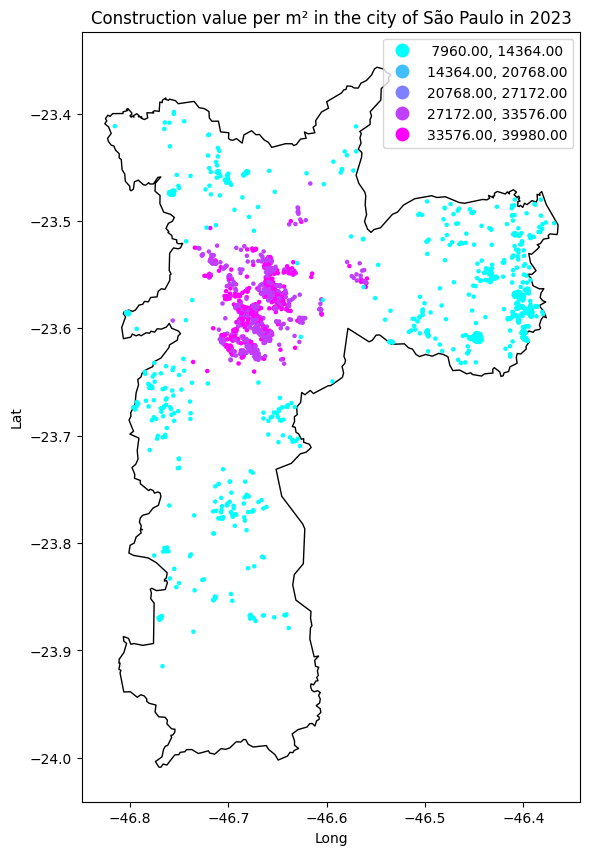

In [18]:
ax2 = sp.plot(color='white', edgecolor='black', figsize=(15,10))
ax = gdf.plot(column='valor_construcao', cmap='cool', markersize=5,
              ax = ax2, legend=True,
              scheme='EqualInterval')
ax.set_title('Construction value per m² in the city of São Paulo in 2023')
ax.set_xlabel('Long')
ax.set_ylabel('Lat')
plt.show()